## ToDo List
- [x] Checar se formato de datas conferem.
- [x] Remover UGs sem liberação OC
- [x] Considerar coluna montagem. Onde estiver vazio, pegar valor de Torres para EOL, no skate.
- [ ] Separar um cojunto aleatório para teste
- [x] Calcular tempos de construção por marco: (IO_realizado - realizado), (CC_realizado - realizado) ...etc  (ordem:IO,CC,ME,OT)
- [x] Calcular atraso da operação comercial (realizado - outorgado)
- [x] Calcular média e dp do tempo de construção.
- [x] Calcular data dos marcos medios (outorgado - tempo_medio_de_construcao) por fonte.
- [x] Calcular atrasos com base nos marcos medios
- [ ] Calcular media e dp dos atrasos. 
- [ ] Normalizar os atrasos calculados (atraso - atraso_medio)/dp
- [x] Construir matriz de correlação de Pearson
- [ ] Calcular os coeficientes para regressão linear
- [x] Para UHE pegar todas UGs, para as demais pegar a primeira UG apenas 
- [ ] Comparar pegando primeira UG e media por grupo



In [1]:
import pandas as pd
import numpy as np
import re
import pyodbc
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from itertools import combinations

In [2]:
def outliers(df:pd.DataFrame,cols : list):
    index_outliers =  []
    for col in cols:
        s = df[col]
        Q1 = s.quantile(0.1)
        Q3 = s.quantile(0.9)
        lower_bound =  Q1
        upper_bound =  Q3 
        index_outliers.extend(s.index[(s < lower_bound) | (s > upper_bound)])
    return set(index_outliers)

#### Transforma coluna IdeUsinaOutorga das UHEs para que cada UG possua esse campo diferente. Por exemplo as UGs da usina 12 serão 12_0, 12_1...

In [3]:
bd_combined = pd.read_parquet("bd_combined.gzip")

In [4]:
bd_combined[bd_combined.IdeUsinaOutorga==27339]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,DatConclusaoTorresRealizado,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,NaT,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,NaT,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


In [5]:
bd_combined.index.name = "idx"
bd_combined.IdeUsinaOutorga = bd_combined.IdeUsinaOutorga.astype(str)
mask = (bd_combined.SigTipoGeracao == "UHE") & (bd_combined.IdeUsinaOutorga.duplicated(keep=False))
bd_combined.loc[mask,"IdeUsinaOutorga"] = bd_combined.loc[mask,"IdeUsinaOutorga"] +"_"+ bd_combined.loc[mask].groupby("IdeUsinaOutorga").cumcount().astype(str)
bd_combined.sample(15)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,DatConclusaoTorresRealizado,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
1791,31983,NaT,NaT,2015-05-27,2015-06-13,RR,21.32,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,UTE,13,21.32,bdworgs,None
853,30238,2010-01-10,2010-02-10,2010-05-12,2010-10-08,SP,7.00,NaT,2009-11-15,NaT,...,NaT,NaT,NaT,NaT,NaT,UTE,1,7.00,bdworgs,None
4720,44538,2024-12-01,2025-01-01,NaT,NaT,MG,48118.00,2024-01-01,NaT,NaT,...,NaT,NaT,NaT,2024-04-01,NaT,UFV,14,48118.00,skate,2021-06-15
3839,37173,2024-11-09,2024-12-06,NaT,NaT,SC,17400.00,2023-04-30,NaT,2023-10-06,...,NaT,2024-09-13,NaT,2024-01-10,NaT,PCH,1,5800.00,skate,2020-04-14
5814,51786,2023-11-30,2023-12-30,NaT,NaT,BA,31500.00,2023-03-05,NaT,2023-06-03,...,NaT,NaT,NaT,2023-03-05,NaT,EOL,7,31500.00,skate,2022-01-18
4730,44553,2022-01-26,2022-02-18,2021-10-22,2021-12-22,PE,49500.00,2021-02-12,2020-12-07,2021-05-18,...,2021-10-31,NaT,NaT,2021-04-24,2021-02-15,EOL,1,5500.00,skate,2020-05-12
3237,34507,2022-11-17,2023-01-01,2021-12-25,2022-01-28,BA,46200.00,2022-03-15,2020-09-21,2022-05-01,...,2021-08-12,NaT,NaT,2022-04-01,2021-01-15,EOL,1,4200.00,skate,2018-05-16
652,29707_30,2015-01-01,2015-05-01,2014-07-04,2014-08-16,RO,3568.00,2008-12-01,2008-09-15,2010-04-01,...,NaT,2011-11-15,2012-01-23,NaT,2010-10-01,UHE,1,69.59,bdworgs,None
5074,47183,2023-09-12,2023-11-12,NaT,NaT,BA,50400.00,2022-11-29,NaT,2022-12-29,...,NaT,NaT,NaT,2022-12-29,NaT,EOL,2,8400.00,skate,2021-12-07


In [7]:
bd_combined[bd_combined.IdeUsinaOutorga=="27339"]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,DatConclusaoTorresRealizado,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,NaT,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,NaT,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


#### Remove linhas cujas colunas DatUGInicioOpComerOutorgado e DatLiberOpComerRealizado não sejam nulas

In [8]:
bd_combined = bd_combined[bd_combined.DatUGInicioOpComerOutorgado.notna()
                            & bd_combined.DatLiberOpComerRealizado.notna()].copy(deep=True)

In [9]:
bd_combined[bd_combined.IdeUsinaOutorga=="27339"]

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,DatConclusaoTorresRealizado,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
95,27339,2017-04-01,2017-05-01,2018-07-28,2018-08-21,SP,11.0,NaT,2016-11-15,NaT,...,NaT,NaT,NaT,NaT,2016-11-15,UTE,1,6.0,bdworgs,None
96,27339,NaT,1994-01-01,1994-01-01,1994-01-01,SP,11.0,NaT,2016-11-15,NaT,...,NaT,NaT,NaT,NaT,2016-11-15,UTE,1,5.0,bdworgs,None


In [11]:
nomes_tempo_construcao = {
    "IO_OC" : "DatInicioObraRealizado",
    "CC_OC" : "DatConcretagemRealizado",
    "ME_OC" : "DatMontagemRealizado",
    "MT_OC" : "DatConclusaoTorresRealizado",
    "OT_OC" : "DatLiberacaoSFGTeste"
} 

tempo_construcao_por_UG = bd_combined[["IdeUsinaOutorga","SigTipoGeracao"]].copy(deep=True)
for nome,marco in nomes_tempo_construcao.items():
    tempo_construcao_por_UG[nome] = bd_combined["DatLiberOpComerRealizado"]-  bd_combined[marco]

tempo_construcao_por_UG["Atraso"]  =  bd_combined["DatLiberOpComerRealizado"]-  bd_combined["DatUGInicioOpComerOutorgado"] 
tempo_construcao_por_UG.head(25)

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,MT_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,1532 days,855 days,346 days,NaT,8 days,665 days
1,12_1,UHE,1609 days,932 days,402 days,NaT,12 days,192 days
2,19,UTE,581 days,NaT,NaT,NaT,6 days,2299 days
3,42_0,UHE,1521 days,NaT,NaT,NaT,10 days,608 days
4,42_1,UHE,1553 days,NaT,NaT,NaT,11 days,0 days
5,42_2,UHE,1615 days,NaT,NaT,NaT,24 days,0 days
6,127,UTE,561 days,NaT,NaT,NaT,NaT,15 days
7,161,PCH,1163 days,677 days,510 days,NaT,38 days,2290 days
9,291,PCH,697 days,419 days,140 days,NaT,45 days,1676 days


In [12]:
is_first = True 
combinacoes = list(combinations([x for x in tempo_construcao_por_UG.columns if x not in ["IdeUsinaOutorga","SigTipoGeracao","Atraso"]],2))
#combinacoes = list(combinations(["IO","CC","ME","MT","OT"],2))

for p_marco, s_marco in combinacoes:
    idx_loop =  ((tempo_construcao_por_UG[p_marco] >= tempo_construcao_por_UG[s_marco]) | 
                 tempo_construcao_por_UG[p_marco].isna() | 
                 tempo_construcao_por_UG[s_marco].isna())

    idx = idx_loop if is_first else (idx & idx_loop)
    is_first = False 

#idx_usinas = idx & (tempo_construcao_por_UG.IO_OC.notna())
tempo_construcao_por_UG_filtered = tempo_construcao_por_UG[idx].copy(deep=True)
tempo_construcao_por_UG_filtered

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,MT_OC,OT_OC,Atraso
idx,,,,,,,,
0,12_0,UHE,1532 days,855 days,346 days,NaT,8 days,665 days
1,12_1,UHE,1609 days,932 days,402 days,NaT,12 days,192 days
2,19,UTE,581 days,NaT,NaT,NaT,6 days,2299 days
3,42_0,UHE,1521 days,NaT,NaT,NaT,10 days,608 days
4,42_1,UHE,1553 days,NaT,NaT,NaT,11 days,0 days
...,...,...,...,...,...,...,...,...
5752,50872,UTE,98 days,NaT,98 days,NaT,41 days,-920 days
5776,51444,UTE,99 days,NaT,99 days,NaT,22 days,-385 days
5782,51450,UTE,104 days,NaT,104 days,NaT,26 days,-380 days


In [15]:
tempo_construcao_por_UG_filtered[tempo_construcao_por_UG_filtered.IdeUsinaOutorga=="27339"]

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,MT_OC,OT_OC,Atraso
idx,,,,,,,,
95,27339,UTE,644 days,NaT,597 days,NaT,24 days,477 days


In [16]:
tempo_construcao_por_UG[~idx]

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,MT_OC,OT_OC,Atraso
idx,,,,,,,,
96,27339,UTE,-8354 days,NaT,-8401 days,NaT,0 days,0 days
223,28462,UTE,-1560 days,NaT,NaT,NaT,71 days,180 days
292,28780,PCH,885 days,454 days,546 days,NaT,79 days,349 days
293,28780,PCH,885 days,454 days,546 days,NaT,79 days,318 days
345,28857,EOL,779 days,748 days,202 days,247 days,110 days,551 days
...,...,...,...,...,...,...,...,...
4742,44554,EOL,380 days,313 days,169 days,64 days,91 days,-75 days
4743,44554,EOL,380 days,313 days,169 days,64 days,85 days,-76 days
4744,44554,EOL,380 days,313 days,169 days,64 days,104 days,-77 days


In [29]:
idx_primeira_ug =  bd_combined[idx].groupby(["IdeUsinaOutorga"],sort=False).DatLiberOpComerRealizado.idxmin()
bd_combined_usinas =   bd_combined.loc[idx_primeira_ug,:]
bd_combined_usinas.sample(10)

,IdeUsinaOutorga,DatInicioOpTesteOutorgada,DatUGInicioOpComerOutorgado,DatLiberacaoSFGTeste,DatLiberOpComerRealizado,UFUsina,VlrPotenciaOutorgada,DatInicioObraOutorgado,DatInicioObraRealizado,DatConcretagemOutorgado,...,DatConclusaoTorresRealizado,DatEnchimentoOutorgado,DatEnchimentoRealizado,DatSisTransmissaoOutorgado,DatSisTransmissaoRealizado,SigTipoGeracao,Quant_UG,Pot_UG,origem,DatOutorgaUsina
idx,,,,,,,,,,,,,,,,,,,,,
1597,31581,2015-12-15,2016-01-01,2015-12-05,2016-01-16,PI,28.90,2015-03-15,2015-01-05,2015-05-01,...,2015-05-15,NaT,NaT,2015-04-01,2015-02-06,EOL,17,28.9000,bdworgs,None
2962,33022,2021-02-01,2021-03-03,2021-01-23,2021-03-13,PI,31500.00,NaT,2020-06-23,NaT,...,2021-01-17,NaT,NaT,2019-06-13,2019-05-15,EOL,10,31500.0000,skate,2019-04-02
1001,30385_2,2015-04-02,2015-04-30,2015-04-10,2015-04-30,AP,252.00,2011-10-14,2011-10-14,2012-11-30,...,NaT,2014-07-30,2014-07-25,2011-07-18,2012-08-02,UHE,1,84.0000,bdworgs,None
2250,35708,2017-01-04,2017-01-14,2016-12-31,2017-01-31,PA,8.04,2016-09-18,2016-11-15,NaT,...,NaT,NaT,NaT,2016-11-27,2016-12-05,UTE,1,0.6216,bdworgs,None
2318,40572,2020-08-01,2020-09-01,2019-09-20,2019-10-16,MA,27.00,2020-02-01,2019-02-18,2020-05-01,...,2019-07-30,NaT,NaT,2020-07-01,2019-04-30,EOL,10,27.0000,bdworgs,None
2223,34777,2018-10-15,2018-11-01,2018-09-29,2018-12-27,BA,20.00,2018-05-01,2018-03-15,2018-07-01,...,2018-08-15,NaT,NaT,2018-05-01,2018-06-15,EOL,10,20.0000,bdworgs,None
1885,32353,2017-09-15,2017-10-01,2017-08-24,2017-12-07,RN,20.00,2017-04-01,2017-02-15,2017-06-01,...,2017-06-28,NaT,NaT,2017-04-01,2017-04-15,EOL,10,20.0000,bdworgs,None
4527,40824,2022-02-19,2022-03-19,2020-04-30,2020-05-15,SP,45000.00,2018-12-03,2019-06-01,NaT,...,NaT,NaT,NaT,2018-12-03,2019-09-01,UTE,1,45000.0000,skate,2019-03-19
4567,40883,2021-01-24,2021-02-01,2021-01-29,2021-02-27,CE,29400.00,2020-06-01,2020-06-16,2020-07-01,...,2021-01-15,NaT,NaT,2019-06-01,2020-06-16,EOL,5,21000.0000,skate,2019-07-02


In [30]:
# Atrasos por usinas são calculados com base UG com menor atraso.
tempo_construcao_por_usina = tempo_construcao_por_UG_filtered.loc[idx_primeira_ug,:]
#tempo_construcao_por_usina.set_index(keys = "IdeUsinaOutorga",inplace=True)
tempo_construcao_por_usina

,IdeUsinaOutorga,SigTipoGeracao,IO_OC,CC_OC,ME_OC,MT_OC,OT_OC,Atraso
idx,,,,,,,,
4,42_1,UHE,1553 days,NaT,NaT,NaT,11 days,0 days
5,42_2,UHE,1615 days,NaT,NaT,NaT,24 days,0 days
6,127,UTE,561 days,NaT,NaT,NaT,NaT,15 days
12,590,UTE,142 days,NaT,111 days,NaT,12 days,-20 days
17,735,PCH,564 days,383 days,261 days,NaT,28 days,1 days
...,...,...,...,...,...,...,...,...
5732,50519,UTE,269 days,NaT,93 days,NaT,20 days,-789 days
5752,50872,UTE,98 days,NaT,98 days,NaT,41 days,-920 days
5776,51444,UTE,99 days,NaT,99 days,NaT,22 days,-385 days


In [32]:
# Cria tabela para calculos por geracao
tempo_construcao_por_geracao = pd.DataFrame()
tempo_construcao_por_geracao["SigTipoGeracao"] = bd_combined.SigTipoGeracao.unique() 


# Realiza calculos por geracao
for coluna in tempo_construcao_por_usina.columns:
    if coluna not in ["IdeUsinaOutorga","SigTipoGeracao"]:
        tempo_construcao_por_geracao[f"{coluna}_media"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].mean())
        #tempo_construcao_por_geracao[f"{coluna}_std"] = tempo_construcao_por_geracao.SigTipoGeracao.apply(lambda x : tempo_construcao_por_usina[tempo_construcao_por_usina.SigTipoGeracao==x][coluna].std())

tempo_construcao_por_geracao.set_index("SigTipoGeracao",inplace=True)
display(tempo_construcao_por_geracao)

,IO_OC_media,CC_OC_media,ME_OC_media,MT_OC_media,OT_OC_media,Atraso_media
SigTipoGeracao,,,,,,
UHE,1781 days 03:46:06.942148768,1600 days 07:01:49.090909088,1429 days 22:50:05.825242720,NaT,56 days 04:55:04.918032787,-129 days +00:00:00
UTE,667 days 01:55:42.857142856,NaT,542 days 06:32:43.636363640,NaT,79 days 07:10:39.252336449,-260 days +09:29:01.935483872
PCH,637 days 16:44:39.069767440,450 days 13:42:51.428571432,274 days 03:20:55.813953488,NaT,59 days 02:05:13.043478261,-124 days +22:57:23.478260870
CGH,389 days 21:49:05.454545456,314 days 07:12:00,191 days 03:00:00,NaT,44 days 03:00:00,-411 days +08:28:14.117647060
EOL,413 days 20:37:23.216080404,344 days 12:25:27.272727272,178 days 18:55:06.122448980,155 days 09:07:30,52 days 14:35:34.673366834,-239 days +06:05:25.628140704
UFV,400 days 23:41:03.157894736,NaT,262 days 19:15:47.368421052,NaT,85 days 07:15:47.368421053,-211 days +19:53:41.052631580


In [33]:
marco_medio_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga"]]
def id_marco(ID,nome,marco):
    geracao = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"SigTipoGeracao"].values[0]
    tempo_medio = tempo_construcao_por_geracao.loc[geracao,f"{nome}_media"]
    data_OC = bd_combined_usinas.loc[bd_combined_usinas.IdeUsinaOutorga==ID,"DatUGInicioOpComerOutorgado"].values[0]
    data_marco_medio = data_OC - tempo_medio
    return data_marco_medio


for nome,marco in nomes_tempo_construcao.items():
    marco_medio_usina[f"{marco}_estimado"] = marco_medio_usina.IdeUsinaOutorga.apply(lambda ID :  id_marco(ID,nome,marco))

In [34]:
marco_medio_usina

,IdeUsinaOutorga,DatInicioObraRealizado_estimado,DatConcretagemRealizado_estimado,DatMontagemRealizado_estimado,DatConclusaoTorresRealizado_estimado,DatLiberacaoSFGTeste_estimado
idx,,,,,,
4,42_1,2000-10-14 20:13:53.057851232,2001-04-13 16:58:10.909090912,2001-10-01 01:09:54.174757280,NaT,2005-07-05 19:04:55.081967213
5,42_2,2000-12-15 20:13:53.057851232,2001-06-14 16:58:10.909090912,2001-12-02 01:09:54.174757280,NaT,2005-09-05 19:04:55.081967213
6,127,2000-06-18 22:04:17.142857144,NaT,2000-10-21 17:27:16.363636360,NaT,2002-01-27 16:49:20.747663551
12,590,2003-12-26 22:04:17.142857144,NaT,2004-04-29 17:27:16.363636360,NaT,2005-08-05 16:49:20.747663551
17,735,2014-06-17 07:15:20.930232560,2014-12-21 10:17:08.571428568,2015-06-15 20:39:04.186046512,NaT,2016-01-16 21:54:46.956521739
...,...,...,...,...,...,...
5732,50519,2022-09-17 22:04:17.142857144,NaT,2023-01-20 17:27:16.363636360,NaT,2024-04-27 16:49:20.747663551
5752,50872,2022-07-29 22:04:17.142857144,NaT,2022-12-01 17:27:16.363636360,NaT,2024-03-08 16:49:20.747663551
5776,51444,2021-06-02 22:04:17.142857144,NaT,2021-10-05 17:27:16.363636360,NaT,2023-01-11 16:49:20.747663551


In [44]:
atraso_usina = tempo_construcao_por_usina.loc[:,["IdeUsinaOutorga","SigTipoGeracao","Atraso"]]
nomes_colunas_atrasos = []
for nome,marco in nomes_tempo_construcao.items():
    nome_coluna = f"{marco}_atraso"
    nomes_colunas_atrasos.append(nome_coluna)
    atraso_usina[nome_coluna] = bd_combined_usinas[marco] - marco_medio_usina[f"{marco}_estimado"]

In [45]:
atraso_usina.sample(10)

,IdeUsinaOutorga,SigTipoGeracao,Atraso,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatConclusaoTorresRealizado_atraso,DatLiberacaoSFGTeste_atraso
idx,,,,,,,,
6,127,UTE,15 days,121 days 01:55:42.857142856,NaT,NaT,NaT,NaT
1850,32319,UFV,83 days,3 days 23:41:03.157894736,NaT,-74 days +19:15:47.368421052,NaT,14 days 07:15:47.368421053
348,28859,UTE,-309 days,57 days 01:55:42.857142856,NaT,76 days 06:32:43.636363640,NaT,-250 days +07:10:39.252336449
75,26792_3,UHE,-742 days,-106 days +03:46:06.942148768,-79 days +07:01:49.090909088,-93 days +22:50:05.825242720,NaT,-701 days +04:55:04.918032787
2190,34437,UFV,-32 days,80 days 23:41:03.157894736,NaT,95 days 19:15:47.368421052,NaT,10 days 07:15:47.368421053
1298,30895,EOL,-26 days,18 days 20:37:23.216080404,-19 days +12:25:27.272727272,-33 days +18:55:06.122448980,-56 days +09:07:30,-3 days +14:35:34.673366834
1621,31610,EOL,-7 days,62 days 20:37:23.216080404,144 days 12:25:27.272727272,25 days 18:55:06.122448980,2 days 09:07:30,9 days 14:35:34.673366834
981,30354_20,UHE,-33 days,-1177 days +03:46:06.942148768,-768 days +07:01:49.090909088,-712 days +22:50:05.825242720,NaT,3 days 04:55:04.918032787
1118,30571,EOL,-55 days,-332 days +20:37:23.216080404,-321 days +12:25:27.272727272,-277 days +18:55:06.122448980,-245 days +09:07:30,-38 days +14:35:34.673366834


Não foi possível calcular: DatConclusaoTorresRealizado_atraso para UHE
Não foi possível calcular: DatConcretagemRealizado_atraso para UTE
Não foi possível calcular: DatConclusaoTorresRealizado_atraso para UTE
Não foi possível calcular: DatConclusaoTorresRealizado_atraso para PCH
Não foi possível calcular: DatConclusaoTorresRealizado_atraso para CGH
Não foi possível calcular: DatConcretagemRealizado_atraso para UFV
Não foi possível calcular: DatConclusaoTorresRealizado_atraso para UFV


,DatInicioObraRealizado_atraso,DatConcretagemRealizado_atraso,DatMontagemRealizado_atraso,DatConclusaoTorresRealizado_atraso,DatLiberacaoSFGTeste_atraso
UHE,15.3%,19.0%,24.1%,-,94.2%
UTE,44.3%,-,42.1%,-,96.6%
PCH,53.6%,72.0%,86.4%,-,94.6%
CGH,89.9%,95.3%,97.7%,-,99.8%
EOL,89.4%,90.6%,94.7%,93.7%,99.3%
UFV,87.0%,-,85.8%,-,95.7%


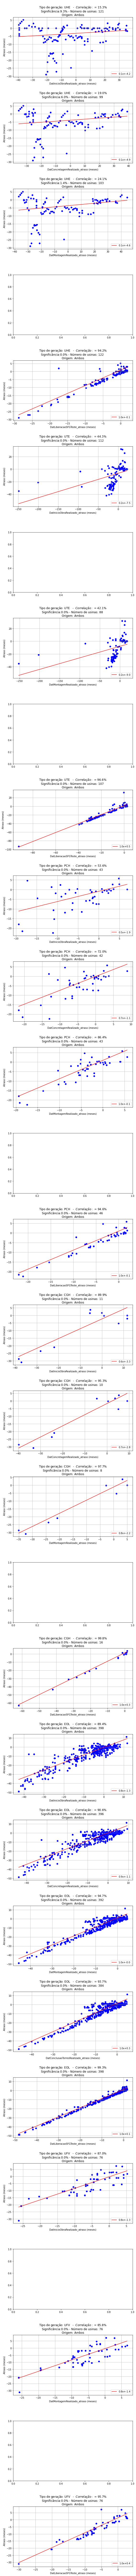

In [101]:
plot_created = False
analises_origem =["Ambos"]     #["skate","bdworgs","Ambos"]
tipos_geracao = tempo_construcao_por_geracao.index.to_list()
matrix_pearson = {}

for k,origem in enumerate(analises_origem):
    
    if not plot_created:    
        num_subplots = (len(tipos_geracao))*(len(nomes_colunas_atrasos))
        fig, axes = plt.subplots(num_subplots,len(analises_origem),figsize=(len(analises_origem)*8,num_subplots*5))
        plot_created =True
    count = -1
    for i,SigTipoGeracao in enumerate(tipos_geracao):
        matrix_pearson[SigTipoGeracao] = []
        for nome_coluna in nomes_colunas_atrasos:
            count+=1
            try:
                ordered_notna = atraso_usina[(atraso_usina[nome_coluna].notna())
                                                 & (atraso_usina.SigTipoGeracao == SigTipoGeracao) ].sort_values(by = nome_coluna)
                x = ordered_notna[nome_coluna].dt.days.to_numpy().reshape(-1, 1)/30
                y = ordered_notna["Atraso"].dt.days.to_numpy().reshape(-1, 1)/30
                res = stats.linregress(x.flatten(), y.flatten())
                a, b, r, p_value, std_err = res
                r_str = f"{100*r:.1f}%"
                matrix_pearson[SigTipoGeracao].append(r_str)
                p_value_str = f"{100*p_value:.1f}%"
                ax = axes[count]
                ax.scatter(x,y,color="blue")
                ax.set_xlabel(f"{nome_coluna} (meses)")
                ax.set_ylabel(f"Atraso (meses)")
                ax.plot(x,a*x+b+1,color="red",label= f"{a:.1f}x+{b:.1f}")
                ax.set_title(f"\nTipo de geração: {SigTipoGeracao}   -  $Correlação:$ = {r_str}\nSignificância:{p_value_str} - Número de usinas: {x.shape[0]} \nOrigem: {origem}")
                ax.legend(loc="lower right")
                ax.grid()
            except (ValueError,AttributeError) as error:
                print(rf"Não foi possível calcular: {nome_coluna} para {SigTipoGeracao}")
                matrix_pearson[SigTipoGeracao].append("-")
matrix_pearson =  pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)
display(matrix_pearson.T)
plt.tight_layout()
plt.savefig("calculos_atrasos.pdf")
person_matrix = pd.DataFrame(matrix_pearson,nomes_colunas_atrasos)